In [1]:
!pip install -r requirements-pube.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/share/miniconda3/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import PIL

In [3]:
PIL.__version__

'6.2.2'

In [4]:
import datetime
import json
import os
from collections import Counter, defaultdict
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import yaml

In [5]:
%matplotlib inline

In [6]:
F.one_hot

<function torch._C._nn.one_hot>

In [7]:
# Add synchronized directory
# Remember to keep up to date on the local machine
distsup_dir = "/home/jovyan/Documents/DistSup"
import sys

sys.path.append(distsup_dir)

In [8]:
from distsup import reconstructors_analysis
from distsup.modules import pixcnn, quantizers
from distsup.reconstructors_analysis.style_modeling.qmnist.dataset import get_dataset

In [9]:
from distsup import utils
from distsup.data import ChunkedDataset, FixedDatasetLoader, PaddedDatasetLoader
from distsup.models import minitest, representation_learners, vqvae
from distsup.modules import encoders, pixcnn, reconstructors
from egs.mnist_seq.data import MNISTSequentialDataset

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda')

## Classes

In [12]:
num_levels = 16

In [13]:
class MnistStyleModel(nn.Module):
    def __init__(self, activation=F.leaky_relu):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 16, kernel_size=3)
        self.fc = nn.Linear(144, 3)
        self.dropout = nn.Dropout2d()
        self.activation = activation

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, :]
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.dropout(x)
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = self.dropout(x)
        x = self.activation(self.conv3(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

    @staticmethod
    def get_inputs(data, num_levels):
        x = data["images"].to(device)
        return (x * num_levels).clamp(0, num_levels - 1) / (num_levels - 1)

In [14]:
style_model = MnistStyleModel()

In [15]:
inps = torch.zeros((8, 4, 28, 28))

In [16]:
style_vecs = torch.empty(8, 4, 3)
for i in range(4):
    style_vecs[:, i, :] = style_model(inps[:, i, :, :].unsqueeze(1))
style_vec = torch.mean(style_vecs, dim=1)

In [17]:
style_vec.shape

torch.Size([8, 3])

In [18]:
digit_cond = [
    {"cond_dim": 3, "reduction_factor": 0,},
    {"cond_dim": 10, "reduction_factor": 0,},
]

In [19]:
style_sizes = [32]  # [1,2,4,8,16,32]

In [20]:
datasets = {i: get_dataset(i + 1) for i in style_sizes}

In [21]:
train_loaders = {
    i: torch.utils.data.DataLoader(
        datasets[i][0], batch_size=64, num_workers=1, shuffle=True
    )
    for i in style_sizes
}

In [22]:
test_loaders = {
    i: torch.utils.data.DataLoader(
        datasets[i][1], batch_size=64, num_workers=1, shuffle=False
    )
    for i in style_sizes
}

In [23]:
models = {
    i: pixcnn.GatedPixelCNN(
        quantizer=dict(
            class_name=quantizers.SoftmaxUniformQuantizer, num_levels=num_levels
        ),
        cond_channels=digit_cond,
    ).to(device)
    for i in style_sizes
}

In [24]:
style_models = {i: MnistStyleModel().to(device) for i in style_sizes}

In [36]:
import os
from typing import Tuple

import torch
import torch.nn.functional as F
import numpy as np
import datetime
import tqdm

from distsup.reconstructors_analysis import style_modeling


class SingleAuthorDigitsTrainer:
    def __init__(
        self,
        model,
        style_model,
        data_loader,
        test_data_loader=None,
        num_levels=16,
        monitor=None,
        serialization_filename=None,
        serialization_path=None,
    ):
        self.model = model
        self.style_model = style_model
        self.data_loader = data_loader
        self.test_data_loader = test_data_loader
        self.dataset: style_modeling.qmnist.dataset.QMNISTSingleAuthorSet = data_loader.dataset
        self.num_levels = num_levels

        self.recon_losses = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.serialization_filename = serialization_filename
        self.serialization_path = serialization_path

        self.monitor = monitor

    def train(self, optimizers, epochs=10):
        try:
            self.train_mode()
            for epoch in range(1, epochs + 1):
                for batch_num, data in enumerate(self.data_loader):
                    inputs, targets = self.get_inputs_and_targets(data)
                    for optimizer in optimizers:
                        optimizer.zero_grad()
                    cond = self.get_conditioning(data)
                    model_output = self.model(inputs, cond)
                    loss = self.get_loss(model_output, targets)
                    loss.backward()
                    loss_item = loss.item()
                    for optimizer in optimizers:
                        optimizer.step()

                    if self.monitor is not None:
                        self.monitor.monitor("loss", loss_item)
                        self.monitor.monitor("batch_num", batch_num)
                    if batch_num % 100 == 0:
                        print(
                            f"Train Epoch: {epoch} [{batch_num * self.data_loader.batch_size}/{len(self.data_loader.dataset)} "
                            f"({100.0 * batch_num / len(self.data_loader):.0f}%)]\tLoss: {loss_item:.6f}"
                        )
                self.recon_losses.append(self.test_model_reconstruction())
        except KeyboardInterrupt:
            print("Interrupting")

    def train_mode(self):
        self.model.train()
        self.style_model.train()

    def eval_mode(self):
        self.model.eval()
        self.style_model.eval()

    def get_inputs_and_targets(self, data) -> Tuple[torch.Tensor, torch.Tensor]:
        target_img = data["target_image"].to(self.device)
        return self.model.get_inputs_and_targets(target_img.permute(0, 2, 3, 1))

    def get_style_vector(self, data):
        batch_size = data["images"].size(0)
        style_input = self.style_model.get_inputs(data, self.num_levels)
        return self.style_model(style_input).view(batch_size, 1, 1, -1)

    def get_conditioning(self, data):
        target_class_label = data["target_image_label"]
        batch_size = target_class_label.size(0)
        target_class_label_one_hot = (
            F.one_hot(target_class_label, 10)
            .view(batch_size, 1, 1, -1)
            .float()
            .to(self.device)
        )
        return self.get_style_vector(data), target_class_label_one_hot

    def get_loss(self, model_output, targets: torch.Tensor):
        raise NotImplementedError

    def sample(self, data, class_label=None):
        raise NotImplementedError

    def get_zeros_like_single_input_shape(self):
        return torch.zeros_like(
            x=self.data_loader.dataset[0]["target_image"][None, :].permute(0, 2, 3, 1)
        ).to(device)

    def compute_image_log_pbb(self, sample, conds):
        with torch.no_grad():
            self.eval_mode()
            # self.image is normalized to 0-1 range, we need integer value of pixels
            _, img_pixels_int = self.get_inputs_and_targets({"target_image": sample})
            model_out = tuple(self.model(sample, conds))[
                0
            ]  # torch.Size([1, 28, 28, 1, 16])
            probabilities = F.log_softmax(model_out.squeeze(), dim=-1).reshape(
                -1, model_out.size(-1)
            )
            # Reshape to 1D vector
            img_pixels_int_vec = img_pixels_int.reshape(-1)
            image_pixels_pbb = probabilities[
                torch.arange(probabilities.size(0)), img_pixels_int_vec
            ]
            return image_pixels_pbb

    def get_sample_log_pbb(self, data, sum_pixels=True):
        with torch.no_grad():
            self.eval_mode()
            conds = self.get_conditioning(data)
            sample_log_pbbs = self.compute_image_log_pbb(
                data["target_image"].to(self.device), conds
            )
            if not sum_pixels:
                return sample_log_pbbs
            return torch.sum(sample_log_pbbs)

    def get_sample_labels_pbb(self, data):
        with torch.no_grad():
            self.eval_mode()
            label_log_pbb = torch.empty(10)
            for label in range(10):
                data["target_image_label"] = torch.tensor([[label]])
                label_log_pbb[label] = self.get_sample_log_pbb(data)
            return label_log_pbb

    def test_generated_sample_class_pbb(self, data, class_label=None):
        with torch.no_grad():
            self.eval_mode()
            if class_label is None:
                class_label = np.random.randint(0, 10)
            class_label = torch.tensor([[class_label]])
            generated_sample = self.sample(data, class_label)
            label_pbb = {}
            for i in range(10):
                cond_data = {
                    "images": data["images"],
                    "target_image_label": torch.tensor([[i]]),
                }
                conds = self.get_conditioning(cond_data)
                label_pbb[i] = torch.sum(
                    self.compute_image_log_pbb(generated_sample, conds)
                )
            return generated_sample, label_pbb

    def get_reconstruction_loss(self, model_output, targets: torch.Tensor):
        return self.model.loss(model_output, targets)

    def nats_per_pix(self, data):
        inputs, targets = self.get_inputs_and_targets(data)
        cond = self.get_conditioning(data)
        model_reconstrution = self.model(inputs, cond)
        rec_loss = self.get_reconstruction_loss(model_reconstrution, targets)
        return torch.mean(rec_loss.view(rec_loss.size(0), -1), dim=-1)  # nats/pix

    def test_model_reconstruction(self, min_num_samples=100):
        with torch.no_grad():
            assert self.test_data_loader is not None
            reconstruction_loss = torch.tensor([]).to(self.device)
            for data in self.test_data_loader:
                inputs, targets = self.get_inputs_and_targets(data)
                cond = self.get_conditioning(data)
                model_reconstrution = self.model(inputs, cond)
                recon_batch = self.get_reconstruction_loss(model_reconstrution, targets)
                reconstruction_loss = torch.cat(
                    (
                        reconstruction_loss,
                        torch.mean(recon_batch.view(recon_batch.size(0), -1), dim=-1),
                    )
                )  # nats/pix
                if (
                    min_num_samples > 0
                    and reconstruction_loss.size(0) >= min_num_samples
                ):
                    break
            return reconstruction_loss

    def _sample_to_input_shape(self, sample):
        return sample[None, :].permute(0, 2, 3, 1).to(self.device)

    def test_model_classification(self, num_samples=100, fake_author_samples=None):
        """
        Computes probability of test images X_0, X_1, ... for all possible digit labels d=0...9.
        Each time P(X_i | style_model(A_i), d) is computed, where A_i are samples of the digit's
        author passed to the style model. The model prediction is value of d that maximizes the term.
        Ths approach bases on the Bayes theorem. if `fake_authors` is set to True, samples passed to
        the style model are not written by the X_i author - P(X_i | style_model(A_j), d) is computed
        then. The `fake_authors` flag may be used to determine the importance of style vector.
        """
        with torch.no_grad():
            self.eval_mode()
            test_data = []
            for i in tqdm.trange(num_samples):
                data = self.test_data_loader.dataset[i]
                label_log_pbb = torch.empty(10)
                sample = self._sample_to_input_shape(data["target_image"])
                for label in range(10):
                    cond_data = {
                        "images": data["images"],
                        "target_image_label": torch.tensor([[label]]),
                    }
                    if fake_author_samples:
                        author_id = np.random.randint(
                            num_samples + 1, len(self.test_data_loader.dataset)
                        )
                        fake_author_data = self.test_data_loader.dataset[author_id]
                        cond_data["images"][:fake_author_samples] = fake_author_data["images"][:fake_author_samples]
                    conds = self.get_conditioning(cond_data)
                    label_log_pbb[label] = torch.sum(
                        self.compute_image_log_pbb(sample, conds)
                    )

                prediction = torch.argmax(label_log_pbb)
                test_data.append(
                    {
                        "data": data,
                        "log_pbbs": label_log_pbb,
                        "prediction": prediction.item(),
                        "correct": (prediction == data["target_image_label"]).item(),
                    }
                )
        return test_data

    def serialize(self, optimizers=None):
        serialize_dict = {
            "model_state_dict": self.model.state_dict(),
            "style_model_state_dict": self.style_model.state_dict(),
            "recon_losses": self.recon_losses,
        }

        if optimizers is not None:
            for i, optimizer in enumerate(optimizers):
                serialize_dict[f"optimizer_{i}"] = optimizer.state_dict()

        serialization_directory = self.serialization_path or "models/"
        serialization_filename = self.serialization_filename or "single_author_digits"
        serialization_filename += type(self.model).__name__
        serialization_path = (
            os.path.join(serialization_directory, serialization_filename)
            + datetime.datetime.now().strftime("_%Y-%m-%d_%H:%M:%S")
            + ".pkl"
        )

        try:
            torch.save(serialize_dict, serialization_path)
        except Exception as e:
            print(f"Could not serialize model. Exception raised: {e}")
            return
        print(f"Model serialized as {serialization_path}")


class PixelCnnSingleAuthorTrainer(SingleAuthorDigitsTrainer):
    def __init__(self, *args, loss_reduction="sum", **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_reduction = loss_reduction
        if self.serialization_filename is None:
            self.serialization_filename = (
                f"PixelCNN_single_author_{self.style_model.samples_num}_style_digits"
            )

    def get_inputs_and_targets(self, data) -> Tuple[torch.Tensor, torch.Tensor]:
        if data["target_image"].size(-1) == 1 and data["target_image"].size(1) != 1:
            data["target_image"] = data["target_image"].permute(0, 3, 1, 2)
        return super().get_inputs_and_targets(data)

    def get_loss(self, model_output, targets: torch.Tensor):
        loss = self.model.loss(model_output, targets)
        if self.loss_reduction == "sum":
            return loss.sum()
        elif self.loss_reduction == "mean":
            return loss.mean()
        else:
            raise "Wrong loss reduction"

    def sample(self, data, class_label=None):
        if class_label is None:
            class_label = np.random.randint(0, 10)
        class_label = torch.tensor([[class_label]])
        self.eval_mode()
        sample = self.get_zeros_like_single_input_shape()
        cond_data = {"images": data["images"], "target_image_label": class_label}
        cond = self.get_conditioning(cond_data)
        for i in range(28):
            for j in range(28):
                pbb = F.softmax(
                    self.model(sample, cond)[:, i, j, :, :].squeeze(), dim=0
                )
                pixel = torch.multinomial(pbb, 1)
                sample[:, i, j, :] = pixel / float(self.num_levels - 1)
        return sample


class PixelCnnSingleAuthorStyleAveragingTrainer(PixelCnnSingleAuthorTrainer):
    def __init__(self, *args, style_vector_size=144, **kwargs):
        super().__init__(*args, **kwargs)
        self.style_vector_size = style_vector_size

    def get_style_vector(self, data):
        if len(data["images"].shape) == 3:
            data["images"] = data["images"][None, :]
        images = data["images"]
        batch_size = images.size(0)
        style_images = images.size(1)

        stacked_style_vectors = torch.empty(
            batch_size, style_images, self.style_vector_size
        ).to(self.device)
        style_input = self.style_model.get_inputs(data, self.num_levels)
        for i in range(style_images):
            stacked_style_vectors[:, i, :] = self.style_model(
                style_input[:, i, :, :].unsqueeze(1)
            )
        style_vector = torch.mean(stacked_style_vectors, dim=1)
        return style_vector.view(batch_size, 1, 1, -1)


class VaeSingleAuthorTrainer(SingleAuthorDigitsTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.serialization_filename = (
            f"VAE_single_author_{self.style_model.samples_num}_style_digits"
        )

    def get_loss(self, model_output, targets: torch.Tensor):
        recon_batch, mu, logvar = model_output
        return self.model.loss(recon_batch, targets, mu, logvar)

    def get_reconstruction_loss(self, model_output, targets: torch.Tensor):
        recon_batch, _, _ = model_output
        return self.model.recon_loss(recon_batch, targets)

    def get_inputs_and_targets(self, data) -> Tuple[torch.Tensor, torch.Tensor]:
        inputs, targets = super().get_inputs_and_targets(data)
        return inputs.permute(0, 3, 1, 2), targets

    def _sample_to_input_shape(self, sample):
        return sample[None, :].to(self.device)

    def sample(self, data, class_label=None):
        if class_label is None:
            class_label = np.random.randint(0, 10)
        class_label = torch.tensor([[class_label]])
        self.eval_mode()
        cond_data = {"images": data["images"], "target_image_label": class_label}
        cond = self.get_conditioning(cond_data)
        z = torch.rand((1, self.model.hidden_vector_size)).to(self.device)
        decoded = self.model.decode(z, cond)
        pbbs = F.softmax(decoded, dim=-1).reshape(-1, self.num_levels)
        sample = torch.multinomial(pbbs, 1) / float(self.num_levels - 1)
        return sample.reshape(1, 1, 28, 28)


class PixelCnnSelfConditioningTrainer(PixelCnnSingleAuthorStyleAveragingTrainer):
    def __init__(self, *args, digit_cond_model, **kwargs):
        super().__init__(*args, **kwargs)
        self.digit_cond_model = digit_cond_model

    def train_mode(self):
        super().train_mode()
        self.digit_cond_model.train()

    def eval_mode(self):
        super().eval_mode()
        self.digit_cond_model.eval()

    def get_conditioning(self, data):
        batch_size = data["target_image"].size(0)
        digit_cond = self.digit_cond_model(data["target_image"].to(self.device)).view(
            batch_size, 1, 1, -1
        )
        return self.get_style_vector(data), digit_cond


In [37]:
trainers = {
    i: PixelCnnSingleAuthorStyleAveragingTrainer(
        models[i],
        style_models[i],
        train_loaders[i],
        test_data_loader=test_loaders[i],
        style_vector_size=3,
        serialization_filename=f"PixelCNN_averaged_style_inputs_{i}",
        serialization_path="models/PixelCNN_averaged_style_3D",
    )
    for i in style_sizes
}

In [39]:
optims = {i: optim.Adam(models[i].parameters(), lr=1e-4) for i in style_sizes}

In [40]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-4) for i in style_models
}

In [48]:
num_epochs = 70

In [41]:
for i in style_sizes:
    print(f"Starting size {i} training")
    trainers[i].train([optims[i], style_optims[i]], 40)
    print("Serializing model")
    trainers[i].serialize([optims[i], style_optims[i]])

Starting size 32 training
Train Epoch: 1 [0/28560 (0%)]	Loss: 16719.080078
Train Epoch: 1 [6400/28560 (22%)]	Loss: 16767.564453
Train Epoch: 1 [12800/28560 (45%)]	Loss: 16900.439453
Train Epoch: 1 [19200/28560 (67%)]	Loss: 17048.242188
Train Epoch: 1 [25600/28560 (89%)]	Loss: 16622.210938
Train Epoch: 2 [0/28560 (0%)]	Loss: 16404.255859
Train Epoch: 2 [6400/28560 (22%)]	Loss: 17264.949219
Train Epoch: 2 [12800/28560 (45%)]	Loss: 16578.929688
Train Epoch: 2 [19200/28560 (67%)]	Loss: 17077.595703
Train Epoch: 2 [25600/28560 (89%)]	Loss: 16834.119141
Train Epoch: 3 [0/28560 (0%)]	Loss: 16749.136719
Train Epoch: 3 [6400/28560 (22%)]	Loss: 16060.868164
Train Epoch: 3 [12800/28560 (45%)]	Loss: 17904.894531
Train Epoch: 3 [19200/28560 (67%)]	Loss: 15966.737305
Train Epoch: 3 [25600/28560 (89%)]	Loss: 16609.753906
Train Epoch: 4 [0/28560 (0%)]	Loss: 16619.343750
Train Epoch: 4 [6400/28560 (22%)]	Loss: 16263.772461
Train Epoch: 4 [12800/28560 (45%)]	Loss: 17385.691406
Train Epoch: 4 [19200/2856

In [45]:
optims = {i: optim.Adam(models[i].parameters(), lr=1e-3) for i in style_sizes}

In [46]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-3) for i in style_models
}

In [50]:
for i in style_sizes:
    print(f"Starting size {i} training")
    trainers[i].train([optims[i], style_optims[i]], num_epochs)
    print("Serializing model")
    trainers[i].serialize([optims[i], style_optims[i]])

Starting size 32 training
Train Epoch: 1 [0/28560 (0%)]	Loss: 15900.956055
Train Epoch: 1 [6400/28560 (22%)]	Loss: 18389.628906
Train Epoch: 1 [12800/28560 (45%)]	Loss: 17297.820312
Train Epoch: 1 [19200/28560 (67%)]	Loss: 16805.578125
Train Epoch: 1 [25600/28560 (89%)]	Loss: 17070.082031
Train Epoch: 2 [0/28560 (0%)]	Loss: 17473.275391
Train Epoch: 2 [6400/28560 (22%)]	Loss: 17588.669922
Train Epoch: 2 [12800/28560 (45%)]	Loss: 16544.394531
Train Epoch: 2 [19200/28560 (67%)]	Loss: 16401.921875
Train Epoch: 2 [25600/28560 (89%)]	Loss: 16692.566406
Train Epoch: 3 [0/28560 (0%)]	Loss: 17117.464844
Train Epoch: 3 [6400/28560 (22%)]	Loss: 16028.774414
Train Epoch: 3 [12800/28560 (45%)]	Loss: 16158.785156
Train Epoch: 3 [19200/28560 (67%)]	Loss: 15246.667969
Train Epoch: 3 [25600/28560 (89%)]	Loss: 16991.484375
Train Epoch: 4 [0/28560 (0%)]	Loss: 16903.214844
Train Epoch: 4 [6400/28560 (22%)]	Loss: 15883.910156
Train Epoch: 4 [12800/28560 (45%)]	Loss: 15965.500000
Train Epoch: 4 [19200/2856

In [54]:
optims = {i: optim.Adam(models[i].parameters(), lr=1e-4) for i in style_sizes}

In [55]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-4) for i in style_models
}

In [57]:
for i in style_sizes:
    print(f"Starting size {i} training")
    trainers[i].train([optims[i], style_optims[i]], num_epochs)
    print("Serializing model")
    trainers[i].serialize([optims[i], style_optims[i]])

Starting size 32 training
Train Epoch: 1 [0/28560 (0%)]	Loss: 13971.814453
Train Epoch: 1 [6400/28560 (22%)]	Loss: 14076.742188
Train Epoch: 1 [12800/28560 (45%)]	Loss: 14553.134766
Train Epoch: 1 [19200/28560 (67%)]	Loss: 14006.771484
Train Epoch: 1 [25600/28560 (89%)]	Loss: 13924.177734
Train Epoch: 2 [0/28560 (0%)]	Loss: 14521.663086
Train Epoch: 2 [6400/28560 (22%)]	Loss: 15137.713867
Train Epoch: 2 [12800/28560 (45%)]	Loss: 14274.755859
Train Epoch: 2 [19200/28560 (67%)]	Loss: 14941.960938
Train Epoch: 2 [25600/28560 (89%)]	Loss: 14389.341797
Train Epoch: 3 [0/28560 (0%)]	Loss: 14956.152344
Train Epoch: 3 [6400/28560 (22%)]	Loss: 14684.668945
Train Epoch: 3 [12800/28560 (45%)]	Loss: 14110.019531
Train Epoch: 3 [19200/28560 (67%)]	Loss: 14152.321289
Train Epoch: 3 [25600/28560 (89%)]	Loss: 13894.437500
Train Epoch: 4 [0/28560 (0%)]	Loss: 14807.201172
Train Epoch: 4 [6400/28560 (22%)]	Loss: 14042.951172
Train Epoch: 4 [12800/28560 (45%)]	Loss: 13521.709961
Train Epoch: 4 [19200/2856

In [58]:
rec_losses = {
    i: [r.mean().item() for r in trainers[i].recon_losses] for i in style_sizes
}

In [59]:
for i, r in rec_losses.items():
    print(i, r[-1], len(r))

32 0.28504833579063416 190


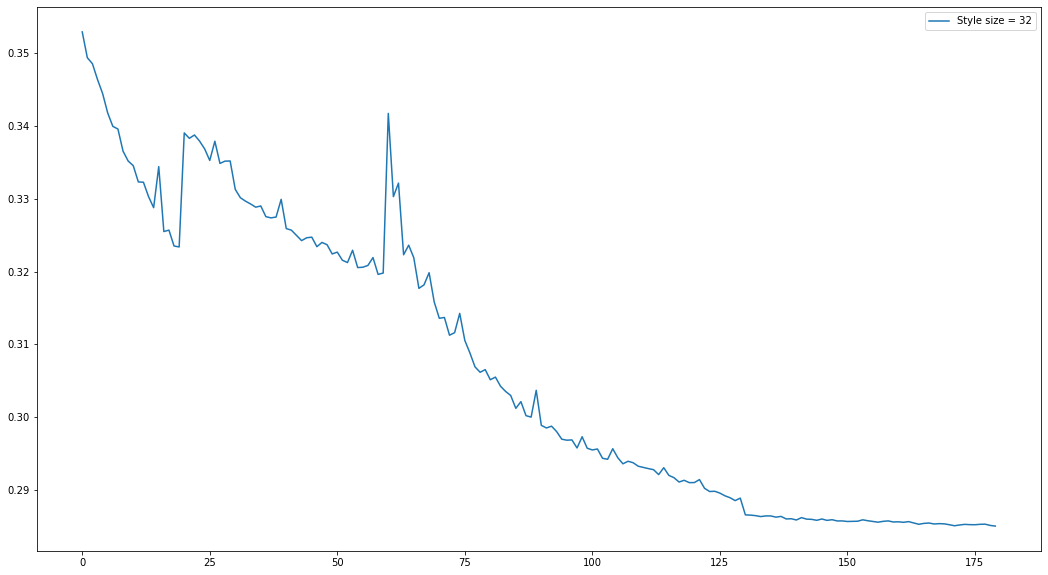

In [60]:
fig = plt.figure(figsize=(18, 10))
for s in style_sizes:
    plt.plot(
        np.arange(len(rec_losses[s]) - 10),
        rec_losses[s][10:],
        label=f"Style size = {s}",
    )
plt.legend()

In [63]:
for size in style_sizes:
    models[size].eval()
    style_models[size].eval()
    recs = trainers[size].test_model_reconstruction(2500)
    print(size, recs.mean().item())

32 0.26956653594970703


In [61]:
def plot_models_samples(num_samples=10):
    fig, axs = plt.subplots(num_samples, len(style_sizes), figsize=(10, 18))
    for digit in range(num_samples):
        author_id = np.random.randint(0, 5000)
        print(f"Digit {digit} author ID: {author_id}")
        for i, trainer in enumerate(list(trainers.values())):
            data = trainer.test_data_loader.dataset[author_id]
            sample = trainer.sample(data, digit)
            axs[digit].imshow(sample.data.cpu().view(28, 28), cmap="gray")
    plt.show()

Digit 0 author ID: 1211
Digit 1 author ID: 292
Digit 2 author ID: 570
Digit 3 author ID: 1864
Digit 4 author ID: 4068
Digit 5 author ID: 466
Digit 6 author ID: 2086
Digit 7 author ID: 1008
Digit 8 author ID: 782
Digit 9 author ID: 793


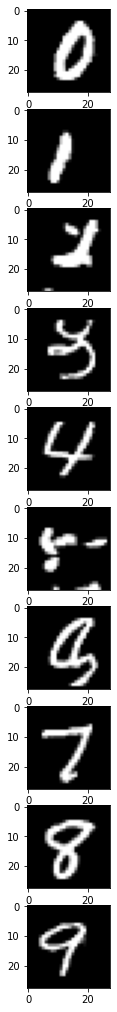

In [62]:
plot_models_samples(10)

In [29]:
models_path = "models/PixelCNN_averaged_style_3D"
model_file_tpl = "PixelCNN_averaged_style_inputs_{}"

In [30]:
models_files = os.listdir(models_path)

In [31]:
training_iter = 0

In [32]:
[file for file in models_files if file.startswith(model_file_tpl.format(32))]

['PixelCNN_averaged_style_inputs_32GatedPixelCNN_2020-08-12_10:51:37.pkl']

In [38]:
for size in style_sizes:
    model_files = [
        file for file in models_files if file.startswith(model_file_tpl.format(size))
    ]
    model_files.sort()
    model_filepath = os.path.join(models_path, model_files[training_iter])
    checkpoint = torch.load(model_filepath)
    models[size].load_state_dict(checkpoint["model_state_dict"])
    style_models[size].load_state_dict(checkpoint["style_model_state_dict"])
    optims[size].load_state_dict(checkpoint["optimizer_0"])
    style_optims[size].load_state_dict(checkpoint["optimizer_1"])
    trainers[size].recon_losses = checkpoint["recon_losses"]

In [39]:
import json

In [64]:
test_data = trainers[32].test_model_classification(2500)
accuracy = sum(t["correct"] for t in test_data) / len(test_data)
print(f"Accuracy: {accuracy}")

100%|██████████| 2500/2500 [17:49<00:00,  2.34it/s]

Accuracy: 0.9796


In [65]:
test_data = trainers[32].test_model_classification(2500, fake_author_samples=32)
accuracy = sum(t["correct"] for t in test_data) / len(test_data)
print(f"Accuracy: {accuracy}")

100%|██████████| 2500/2500 [20:40<00:00,  2.02it/s]

Accuracy: 0.8776


In [99]:
from collections import defaultdict
authors_cond = defaultdict(list)

t = trainers[32]
t.eval_mode()

for i in range(1000):
    for _ in range(3):
        sample = datasets[32][1][i]
        author_id = sample["author_id"].item()
        images = sample["images"][None, :]
        style = t.get_style_vector({
            "images": images
        })
        authors_cond[author_id].append(style.data.cpu().view(-1))

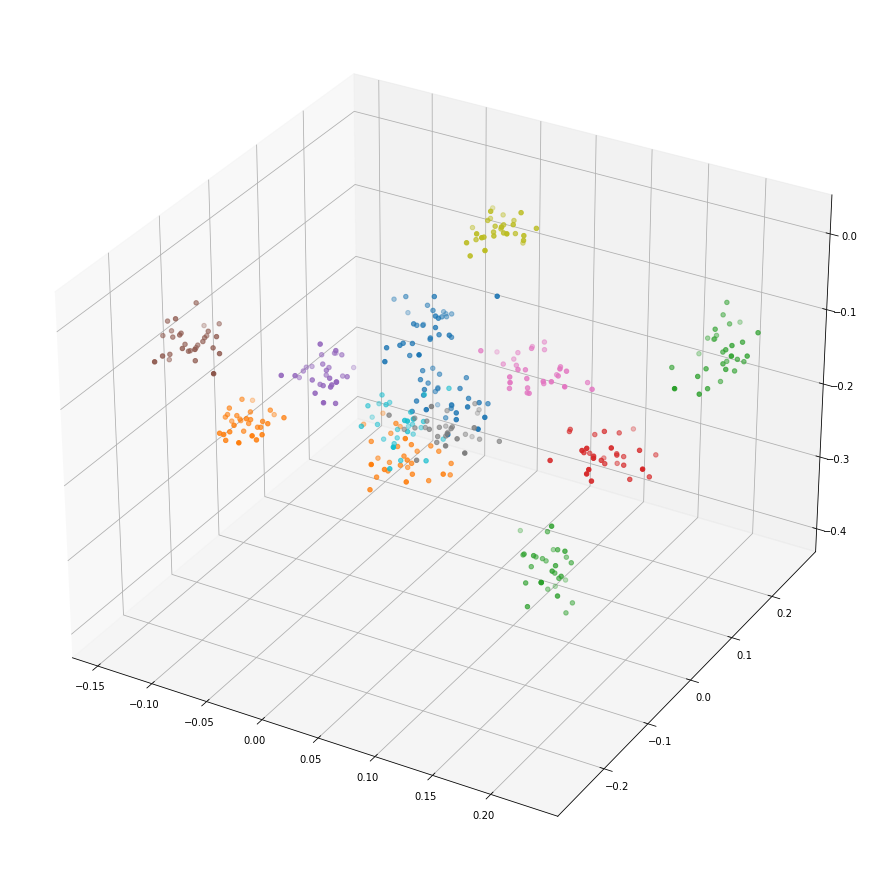

In [101]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)

for d in (list(authors_cond)[:13]):
    X, Y, Z = np.vstack(authors_cond[d]).T
    ax.scatter(X, Y, Z)
plt.show()

In [96]:
np.vstack(authors_cond[3400]).T.mean(0)

array([0.09447446, 0.08648825, 0.10372255, 0.08123177, 0.07128789,
       0.09192545, 0.06308483, 0.09332427, 0.08119734, 0.08278982],
      dtype=float32)

In [89]:
authors_cond.keys()

dict_keys([3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483])